In [1]:
import pandas as pd
import numpy as np
import ast

import os
import matplotlib.pyplot as plt
import seaborn as sns
from plinder_analysis_utils import DockingAnalysisBase, PoseBustersAnalysis, PropertyAnalysis

import statsmodels.formula.api as smf


In [2]:
PLINDER_TEST_COLUMNS = [
    "system_id", "ligand_smiles",
    # binary 
    # "ligand_is_covalent", "ligand_is_ion", "ligand_is_cofactor", "ligand_is_artifact",
    # discrete
    "system_num_protein_chains",
    "ligand_num_rot_bonds", "ligand_num_hbd", "ligand_num_hba", "ligand_num_rings",
    # continuous
    "entry_resolution", "entry_validation_molprobity", 
    "system_num_pocket_residues", "system_num_interactions",
    "ligand_molecular_weight", "ligand_crippen_clogp", 
    "ligand_num_interacting_residues", "ligand_num_neighboring_residues", "ligand_num_interactions",
]
# Create category mapping for visualization
CATEGORY_MAPPING = {
    "ligand_is_covalent": "binary",
    "ligand_is_ion": "binary",
    "ligand_is_cofactor": "binary",
    "ligand_is_artifact": "binary",
    "system_num_protein_chains": "discrete",
    "ligand_num_rot_bonds": "continuous",    
    "ligand_num_hbd": "continuous",
    "ligand_num_hba": "continuous",
    "ligand_num_rings": "continuous",
    "entry_resolution": "continuous",
    "entry_validation_molprobity": "continuous",
    "system_num_pocket_residues": "continuous",
    "system_num_interactions": "continuous",
    "ligand_molecular_weight": "continuous",
    "ligand_crippen_clogp": "continuous",
    "ligand_num_interacting_residues": "continuous",
    "ligand_num_neighboring_residues": "continuous",
    "ligand_num_interactions": "continuous",
    "ligand_is_artifact": "binary"     
}

In [3]:
df_combined = pd.read_csv("plinder_set_0_annotated.csv")

/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_46673/2737273468.py:1: DtypeWarning: Columns (78) have mixed types. Specify dtype option on import or set low_memory=False.
  df_combined = pd.read_csv("plinder_set_0_annotated.csv")


In [4]:
# build a boolean mask: drop any row where covalent, ionic or has_ion is True
# mask = ~(
#     df_combined['ligand_is_covalent'] |
#     df_combined['ligand_is_ion'] |
#     df_combined['has_ion'] |
#     df_combined['ligand_is_cofactor']
# )

# # filter and reset index
# df_combined = df_combined.loc[mask].reset_index(drop=True)
print("Filtered shape:", df_combined.shape)

Filtered shape: (26726, 154)


In [5]:
# First analyze multiple properties
property_analysis = PropertyAnalysis(df_combined)
methods = ["surfdock", "gnina", "chai-1", "diffdock_pocket_only", "icm", "vina"]

# Comparative Between Physics-based and ML-based: Mixed Effect Analysi

## Prepare the df

In [27]:
MIXED_EFFECT_VARS = [
    "protein", "rmsd","method",
    # "system_id", "ligand_smiles",
    # binary 
    # "ligand_is_covalent", "ligand_is_ion", "ligand_is_cofactor", "ligand_is_artifact",
    # discrete
    # "system_num_protein_chains",
    "ligand_num_rot_bonds", "ligand_num_hbd", "ligand_num_hba", "ligand_num_rings",
    # continuous
    "entry_resolution", "entry_validation_molprobity", 
    # "system_num_pocket_residues", 
    "system_num_interactions",
    "ligand_molecular_weight", "ligand_crippen_clogp", 
    "ligand_num_interacting_residues", 
    "ligand_num_neighboring_residues", 
    "ligand_num_interactions",
]

In [28]:
df_mixed = df_combined[MIXED_EFFECT_VARS]
# Create a Method_Type column based on the classification
df_mixed['Method_Type'] = df_mixed['method'].apply(
    lambda x: 'ML' if x in ['chai-1', 'diffdock_pocket_only', 'surfdock'] else 'Physics'
)

# Display the counts of each method type
print(df_mixed['Method_Type'].value_counts())

# Verify the classification
for method in df_mixed['method'].unique():
    method_type = 'ML' if method in ['chai-1', 'diffdock_pocket_only', 'surfdock'] else 'Physics'
    print(f"{method}: {method_type}")

Method_Type
ML         13452
Physics    13274
Name: count, dtype: int64
diffdock_pocket_only: ML
gnina: Physics
icm: Physics
chai-1: ML
vina: Physics
surfdock: ML


/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_46673/953947549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mixed['Method_Type'] = df_mixed['method'].apply(


## Mixed_Effect Analysis

### system_num_protein_chains

In [8]:
property = "ligand_num_rot_bonds"
df_method = (
    df_mixed[[
        "rmsd",
        property,
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
print(df_method.shape)

model = smf.mixedlm(
    f"rmsd ~ {property} * Method_Type",
    data=df_method,
    groups=df_method["protein"]
).fit()

print(model.summary())

(23555, 4)


/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelih

                            Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            rmsd         
No. Observations:             23555              Method:                        REML         
No. Groups:                   918                Scale:                         19103419.0942
Min. group size:              5                  Log-Likelihood:                -230965.3205 
Max. group size:              35                 Converged:                     No           
Mean group size:              25.7                                                           
---------------------------------------------------------------------------------------------
                                              Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
---------------------------------------------------------------------------------------------
Intercept                                       71.300   80.236  0.889 0.374  -85.960 22

### ligand_num_rot_bonds

In [9]:
property = "ligand_num_rot_bonds"
df_method = (
    df_mixed[[
        "rmsd",
        property,
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
print(df_method.shape)

property_analysis.analyze_comparative_fixed_effects(df_method, property, "Method_Type", "rmsd", "protein")

(23555, 4)


/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelih

                            Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            rmsd         
No. Observations:             23555              Method:                        REML         
No. Groups:                   918                Scale:                         19103419.0942
Min. group size:              5                  Log-Likelihood:                -230965.3205 
Max. group size:              35                 Converged:                     No           
Mean group size:              25.7                                                           
---------------------------------------------------------------------------------------------
                                              Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
---------------------------------------------------------------------------------------------
Intercept                                       71.300   80.236  0.889 0.374  -85.960 22

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


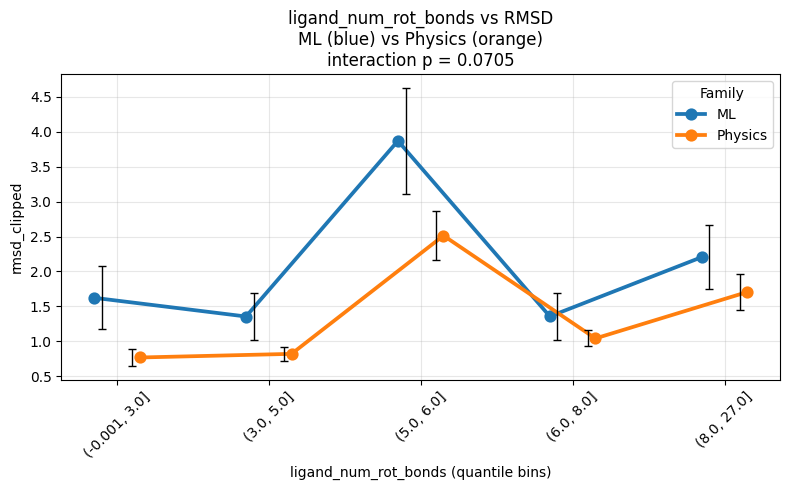

0.07054966953594015
                                               Mixed Linear Model Regression Results
Model:                                     MixedLM                         Dependent Variable:                         rmsd_clipped
No. Observations:                          1808                            Method:                                     REML        
No. Groups:                                918                             Scale:                                      4.5308      
Min. group size:                           1                               Log-Likelihood:                             -4158.0205  
Max. group size:                           2                               Converged:                                  Yes         
Mean group size:                           2.0                                                                                     
-------------------------------------------------------------------------------------------------------

In [10]:
results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "gnina", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())


#### without gnina

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


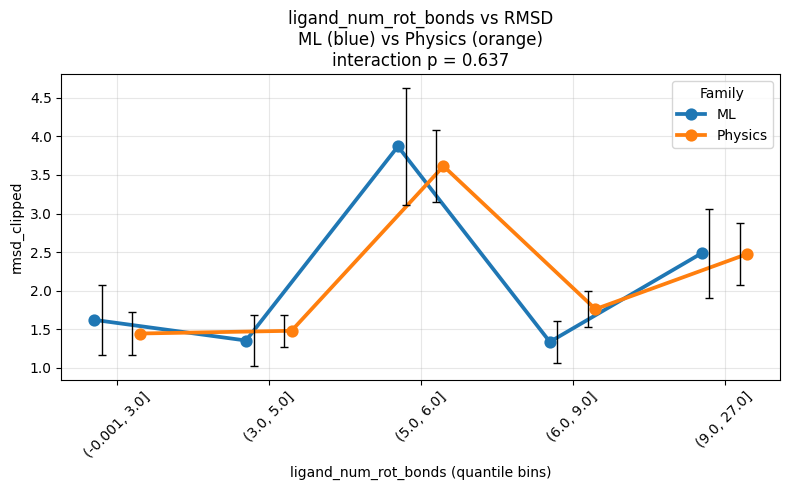

0.6365439325757991
                                               Mixed Linear Model Regression Results
Model:                                     MixedLM                         Dependent Variable:                         rmsd_clipped
No. Observations:                          1768                            Method:                                     REML        
No. Groups:                                908                             Scale:                                      5.5412      
Min. group size:                           1                               Log-Likelihood:                             -4236.6409  
Max. group size:                           2                               Converged:                                  Yes         
Mean group size:                           1.9                                                                                     
--------------------------------------------------------------------------------------------------------

In [11]:
results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())

### ligand_num_hbd

(23545, 4)


/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                         Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          rmsd         
No. Observations:           23545            Method:                      REML         
No. Groups:                 916              Scale:                       19112539.1291
Min. group size:            5                Log-Likelihood:              -230870.5577 
Max. group size:            35               Converged:                   Yes          
Mean group size:            25.7                                                       
---------------------------------------------------------------------------------------
                                        Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
---------------------------------------------------------------------------------------
Intercept                                -16.457   81.019 -0.203 0.839 -175.252 142.338
Method_Type[T.Physics]                    22.454  108.901

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


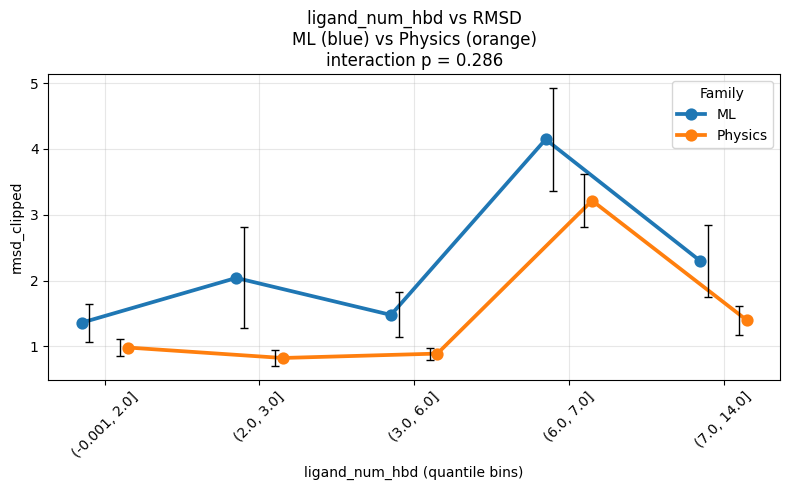

0.2863228154186753
                                            Mixed Linear Model Regression Results
Model:                                   MixedLM                       Dependent Variable:                       rmsd_clipped
No. Observations:                        1806                          Method:                                   REML        
No. Groups:                              916                           Scale:                                    4.5358      
Min. group size:                         1                             Log-Likelihood:                           -4136.2312  
Max. group size:                         2                             Converged:                                Yes         
Mean group size:                         2.0                                                                                 
-----------------------------------------------------------------------------------------------------------------------------
                 

In [12]:
property = "ligand_num_hbd"
df_method = (
    df_mixed[[
        "rmsd",
        property,
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
print(df_method.shape)

property_analysis.analyze_comparative_fixed_effects(df_method, property, "Method_Type", "rmsd", "protein")

results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "gnina", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())


#### without gnina

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


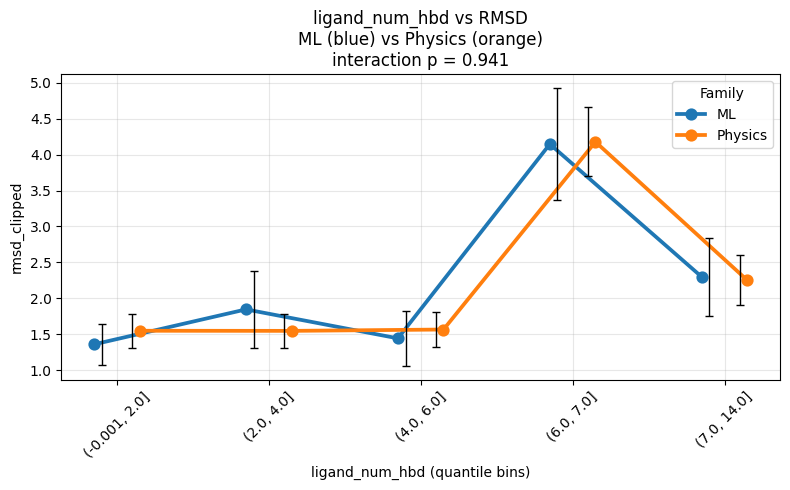

0.9413799282831395
                                            Mixed Linear Model Regression Results
Model:                                   MixedLM                       Dependent Variable:                       rmsd_clipped
No. Observations:                        1765                          Method:                                   REML        
No. Groups:                              906                           Scale:                                    5.5440      
Min. group size:                         1                             Log-Likelihood:                           -4218.4711  
Max. group size:                         2                             Converged:                                Yes         
Mean group size:                         1.9                                                                                 
-----------------------------------------------------------------------------------------------------------------------------
                 

In [13]:
results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())

### ligand_num_hba

(23545, 4)


/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                         Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          rmsd         
No. Observations:           23545            Method:                      REML         
No. Groups:                 916              Scale:                       19113538.9119
Min. group size:            5                Log-Likelihood:              -230871.9043 
Max. group size:            35               Converged:                   Yes          
Mean group size:            25.7                                                       
---------------------------------------------------------------------------------------
                                        Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
---------------------------------------------------------------------------------------
Intercept                                 17.556   90.427  0.194 0.846 -159.678 194.790
Method_Type[T.Physics]                   -10.886  122.426

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


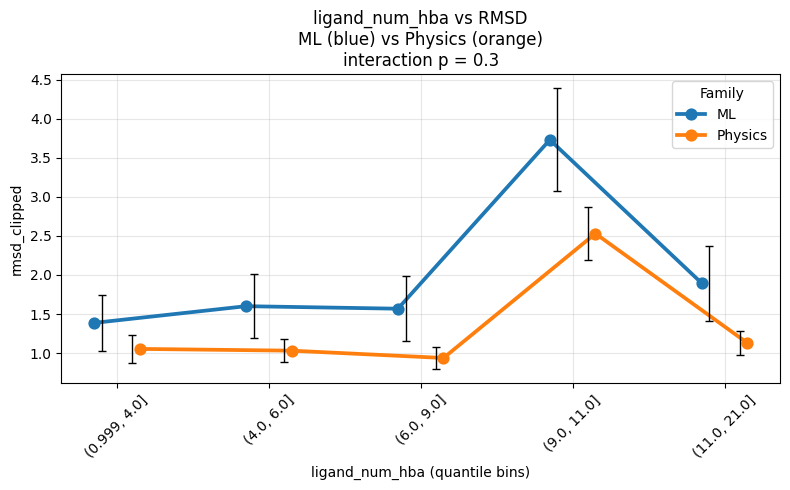

0.2997643769795284
                                            Mixed Linear Model Regression Results
Model:                                    MixedLM                       Dependent Variable:                       rmsd_clipped
No. Observations:                         1806                          Method:                                   REML        
No. Groups:                               916                           Scale:                                    4.5506      
Min. group size:                          1                             Log-Likelihood:                           -4163.7461  
Max. group size:                          2                             Converged:                                Yes         
Mean group size:                          2.0                                                                                 
------------------------------------------------------------------------------------------------------------------------------
          

In [14]:
property = "ligand_num_hba"
df_method = (
    df_mixed[[
        "rmsd",
        property,
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
print(df_method.shape)

property_analysis.analyze_comparative_fixed_effects(df_method, property, "Method_Type", "rmsd", "protein")

results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "gnina", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())


#### without gnina

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


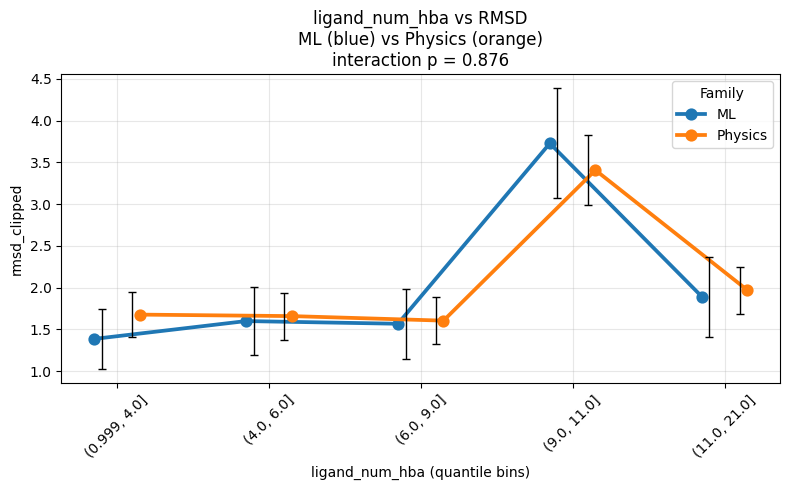

0.8762614875461404
                                            Mixed Linear Model Regression Results
Model:                                    MixedLM                       Dependent Variable:                       rmsd_clipped
No. Observations:                         1765                          Method:                                   REML        
No. Groups:                               906                           Scale:                                    5.5519      
Min. group size:                          1                             Log-Likelihood:                           -4244.9772  
Max. group size:                          2                             Converged:                                Yes         
Mean group size:                          1.9                                                                                 
------------------------------------------------------------------------------------------------------------------------------
          

In [15]:
results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())

### ligand_num_rings

(23545, 4)


/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelih

                          Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           rmsd         
No. Observations:           23545             Method:                       REML         
No. Groups:                 916               Scale:                        19113296.7164
Min. group size:            5                 Log-Likelihood:               -230869.6101 
Max. group size:            35                Converged:                    No           
Mean group size:            25.7                                                         
-----------------------------------------------------------------------------------------
                                          Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------------------------------------
Intercept                                  126.824   93.391  1.358 0.174  -56.219 309.867
Method_Type[T.Physics]              

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


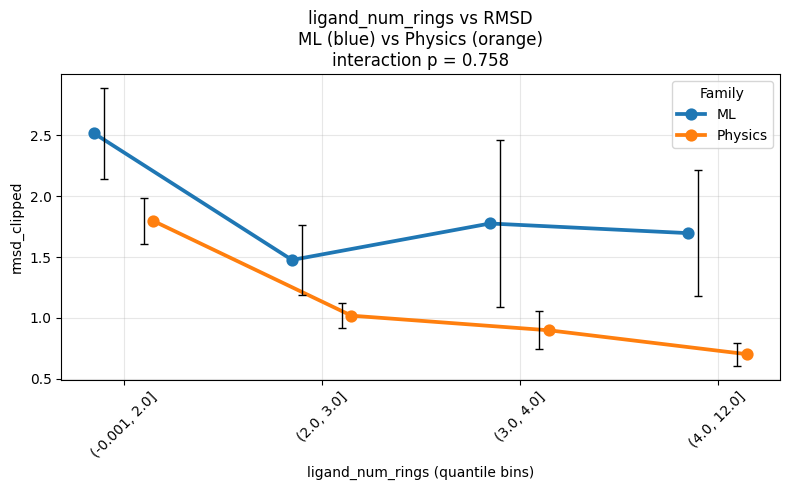

0.7583586580341766
                                             Mixed Linear Model Regression Results
Model:                                   MixedLM                        Dependent Variable:                        rmsd_clipped
No. Observations:                        1806                           Method:                                    REML        
No. Groups:                              916                            Scale:                                     4.5556      
Min. group size:                         1                              Log-Likelihood:                            -4199.9300  
Max. group size:                         2                              Converged:                                 Yes         
Mean group size:                         2.0                                                                                   
-------------------------------------------------------------------------------------------------------------------------------
  

In [16]:
property = "ligand_num_rings"
df_method = (
    df_mixed[[
        "rmsd",
        property,
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
print(df_method.shape)

property_analysis.analyze_comparative_fixed_effects(df_method, property, "Method_Type", "rmsd", "protein")

results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "gnina", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())


#### without gnina

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


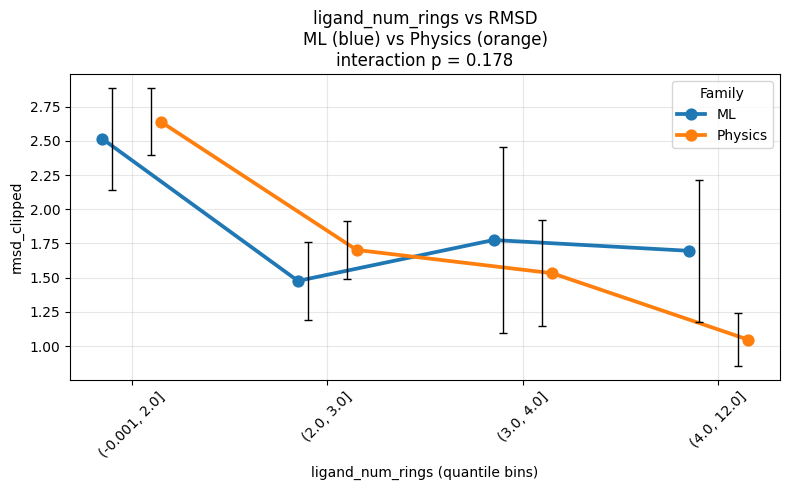

0.17844837951777504
                                             Mixed Linear Model Regression Results
Model:                                   MixedLM                        Dependent Variable:                        rmsd_clipped
No. Observations:                        1765                           Method:                                    REML        
No. Groups:                              906                            Scale:                                     5.4808      
Min. group size:                         1                              Log-Likelihood:                            -4271.0504  
Max. group size:                         2                              Converged:                                 Yes         
Mean group size:                         1.9                                                                                   
-------------------------------------------------------------------------------------------------------------------------------
 

In [17]:
results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())

### entry_resolution

(23545, 4)


/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelih

                          Mixed Linear Model Regression Results
Model:                       MixedLM           Dependent Variable:           rmsd         
No. Observations:            23545             Method:                       REML         
No. Groups:                  916               Scale:                        19103658.8127
Min. group size:             5                 Log-Likelihood:               -230862.2473 
Max. group size:             35                Converged:                    No           
Mean group size:             25.7                                                         
------------------------------------------------------------------------------------------
                                          Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------------------------------
Intercept                                 -569.605  196.806 -2.894 0.004 -955.338 -183.871
Method_Type[T.Physics]    

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


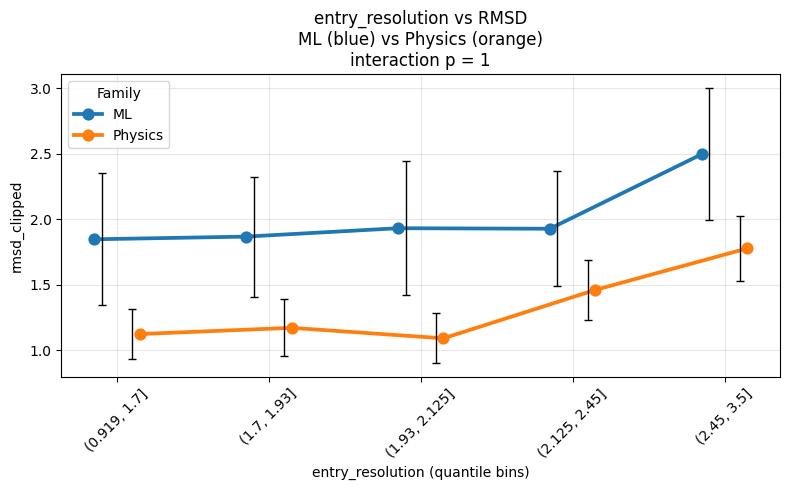

1.0
                                              Mixed Linear Model Regression Results
Model:                                     MixedLM                        Dependent Variable:                        rmsd_clipped
No. Observations:                          1806                           Method:                                    REML        
No. Groups:                                916                            Scale:                                     4.5730      
Min. group size:                           1                              Log-Likelihood:                            -4217.8665  
Max. group size:                           2                              Converged:                                 Yes         
Mean group size:                           2.0                                                                                   
---------------------------------------------------------------------------------------------------------------------------------
  

In [18]:
property = "entry_resolution"
df_method = (
    df_mixed[[
        "rmsd",
        property,
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
print(df_method.shape)

property_analysis.analyze_comparative_fixed_effects(df_method, property, "Method_Type", "rmsd", "protein")

results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "gnina", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())


#### without gnina

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


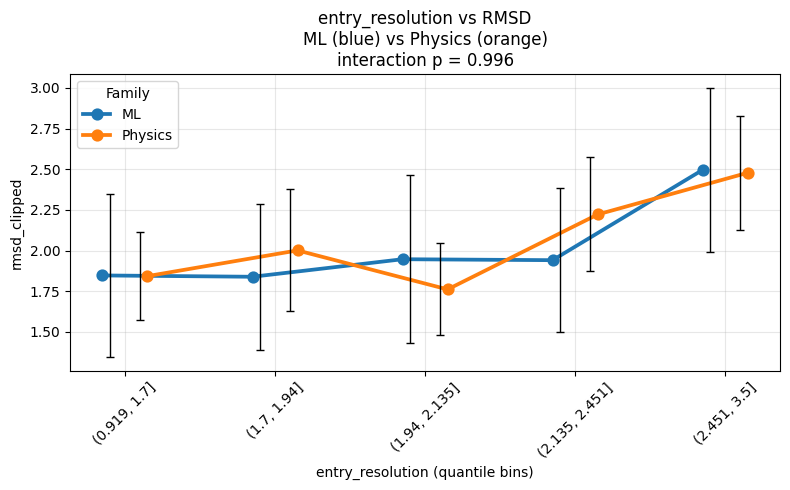

0.9957635521804464
                                              Mixed Linear Model Regression Results
Model:                                    MixedLM                         Dependent Variable:                         rmsd_clipped
No. Observations:                         1765                            Method:                                     REML        
No. Groups:                               906                             Scale:                                      5.5256      
Min. group size:                          1                               Log-Likelihood:                             -4292.7865  
Max. group size:                          2                               Converged:                                  Yes         
Mean group size:                          1.9                                                                                     
---------------------------------------------------------------------------------------------------------------

In [19]:
results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())

### entry_validation_molprobity

(23515, 4)


/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelih

                               Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              rmsd         
No. Observations:                23515                Method:                          REML         
No. Groups:                      914                  Scale:                           19137731.0092
Min. group size:                 5                    Log-Likelihood:                  -230587.0262 
Max. group size:                 35                   Converged:                       No           
Mean group size:                 25.7                                                               
----------------------------------------------------------------------------------------------------
                                                     Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------------------------------------------
Intercept             

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


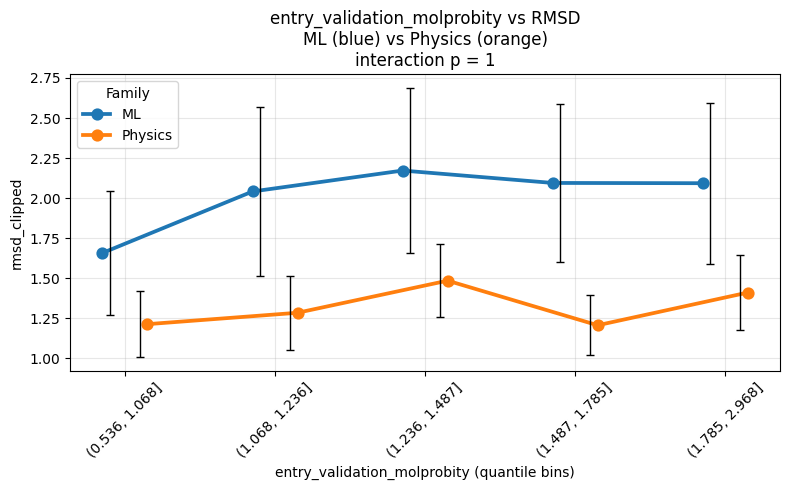

1.0
                                                    Mixed Linear Model Regression Results
Model:                                         MixedLM                            Dependent Variable:                            rmsd_clipped
No. Observations:                              1802                               Method:                                        REML        
No. Groups:                                    914                                Scale:                                         4.5828      
Min. group size:                               1                                  Log-Likelihood:                                -4213.2903  
Max. group size:                               2                                  Converged:                                     Yes         
Mean group size:                               2.0                                                                                           
------------------------------------------------------

In [20]:
property = "entry_validation_molprobity"
df_method = (
    df_mixed[[
        "rmsd",
        property,
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
print(df_method.shape)

property_analysis.analyze_comparative_fixed_effects(df_method, property, "Method_Type", "rmsd", "protein")

results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "gnina", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())


#### without gnina

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


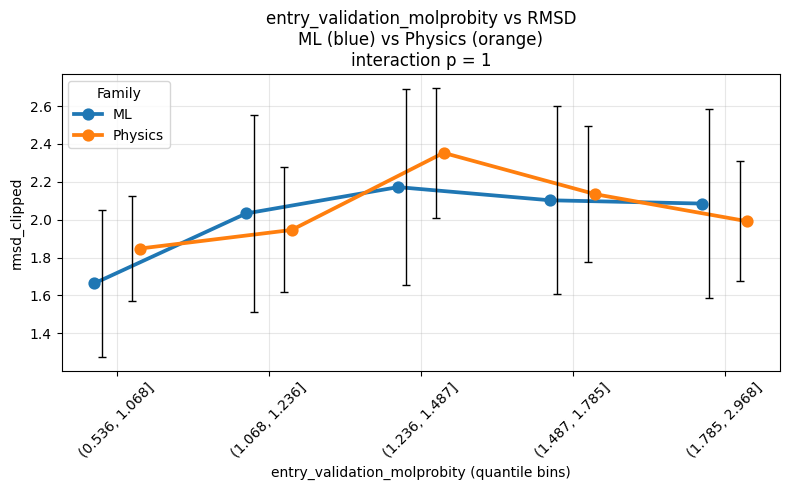

1.0
                                                    Mixed Linear Model Regression Results
Model:                                         MixedLM                            Dependent Variable:                            rmsd_clipped
No. Observations:                              1762                               Method:                                        REML        
No. Groups:                                    904                                Scale:                                         5.5350      
Min. group size:                               1                                  Log-Likelihood:                                -4288.6637  
Max. group size:                               2                                  Converged:                                     Yes         
Mean group size:                               1.9                                                                                           
------------------------------------------------------

In [21]:
results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())

### system_pocket_residues

### system_num_interactions

### ligand_molecular_weight

(23545, 4)


/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelih

                             Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             rmsd         
No. Observations:              23545               Method:                         REML         
No. Groups:                    916                 Scale:                          19113854.7826
Min. group size:               5                   Log-Likelihood:                 -230878.9775 
Max. group size:               35                  Converged:                      No           
Mean group size:               25.7                                                             
------------------------------------------------------------------------------------------------
                                                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------------------------------------
Intercept                                          63.842  1

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


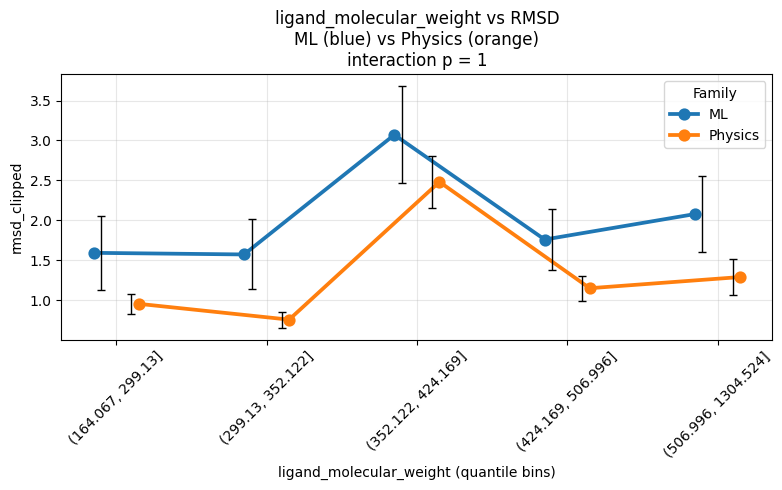

1.0
                                                    Mixed Linear Model Regression Results
Model:                                        MixedLM                             Dependent Variable:                             rmsd_clipped
No. Observations:                             1806                                Method:                                         REML        
No. Groups:                                   916                                 Scale:                                          4.5792      
Min. group size:                              1                                   Log-Likelihood:                                 -4187.7196  
Max. group size:                              2                                   Converged:                                      Yes         
Mean group size:                              2.0                                                                                             
------------------------------------------------

In [22]:
property = "ligand_molecular_weight"
df_method = (
    df_mixed[[
        "rmsd",
        property,
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
print(df_method.shape)

property_analysis.analyze_comparative_fixed_effects(df_method, property, "Method_Type", "rmsd", "protein")

results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "gnina", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())

#### without gnina

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


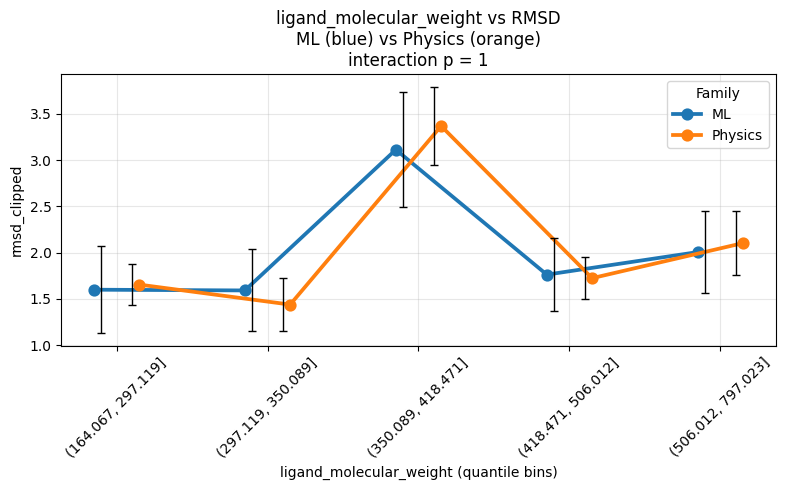

1.0
                                                    Mixed Linear Model Regression Results
Model:                                         MixedLM                            Dependent Variable:                            rmsd_clipped
No. Observations:                              1765                               Method:                                        REML        
No. Groups:                                    906                                Scale:                                         5.5551      
Min. group size:                               1                                  Log-Likelihood:                                -4263.7353  
Max. group size:                               2                                  Converged:                                     Yes         
Mean group size:                               1.9                                                                                           
------------------------------------------------------

In [23]:
results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())

### ligand_crippen_clogp

(23545, 4)


/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelih

                            Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            rmsd         
No. Observations:             23545              Method:                        REML         
No. Groups:                   916                Scale:                         19111027.1813
Min. group size:              5                  Log-Likelihood:                -230870.0902 
Max. group size:              35                 Converged:                     No           
Mean group size:              25.7                                                           
---------------------------------------------------------------------------------------------
                                              Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
---------------------------------------------------------------------------------------------
Intercept                                       59.552   42.971  1.386 0.166  -24.670 14

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


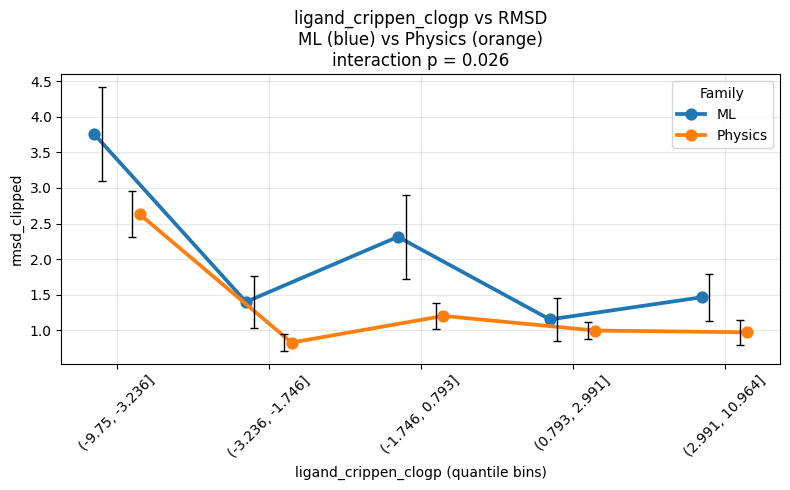

p_interaction: 0.02603896725764446
                                                  Mixed Linear Model Regression Results
Model:                                       MixedLM                           Dependent Variable:                           rmsd_clipped
No. Observations:                            1806                              Method:                                       REML        
No. Groups:                                  916                               Scale:                                        4.5087      
Min. group size:                             1                                 Log-Likelihood:                               -4145.0055  
Max. group size:                             2                                 Converged:                                    Yes         
Mean group size:                             2.0                                                                                         
-------------------------------------------------

In [24]:
property = "ligand_crippen_clogp"
df_method = (
    df_mixed[[
        "rmsd",
        property,
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
print(df_method.shape)

property_analysis.analyze_comparative_fixed_effects(df_method, property, "Method_Type", "rmsd", "protein")

results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "gnina", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(f"p_interaction: {results['p_interaction']}")
print(results['model_full'].summary())
print(results['model_noint'].summary())


#### without gnina

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


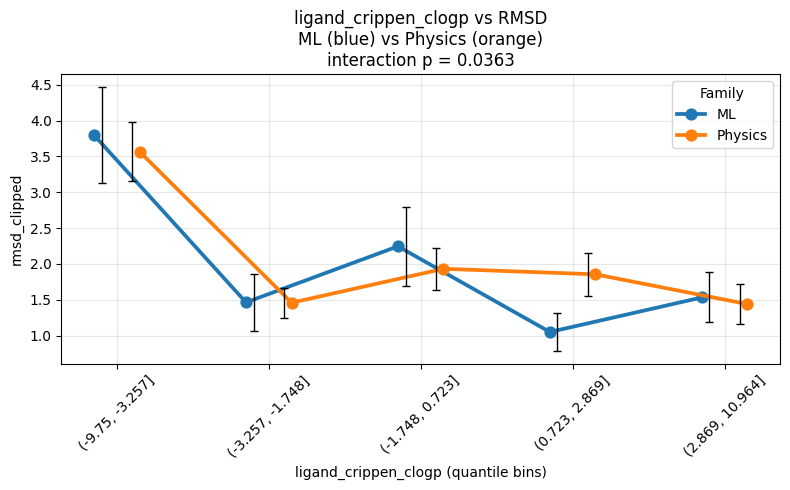

0.03628278382387641
                                                 Mixed Linear Model Regression Results
Model:                                      MixedLM                           Dependent Variable:                           rmsd_clipped
No. Observations:                           1765                              Method:                                       REML        
No. Groups:                                 906                               Scale:                                        5.4918      
Min. group size:                            1                                 Log-Likelihood:                               -4225.0537  
Max. group size:                            2                                 Converged:                                    Yes         
Mean group size:                            1.9                                                                                         
-----------------------------------------------------------------------

In [25]:
results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())

### ligand_num_interactions

(23545, 4)


/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/aoxu/miniconda3/envs/molpal/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelih

                             Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             rmsd         
No. Observations:              23545               Method:                         REML         
No. Groups:                    916                 Scale:                          19110367.9098
Min. group size:               5                   Log-Likelihood:                 -230871.0594 
Max. group size:               35                  Converged:                      No           
Mean group size:               25.7                                                             
------------------------------------------------------------------------------------------------
                                                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------------------------------------
Intercept                                         230.857   

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


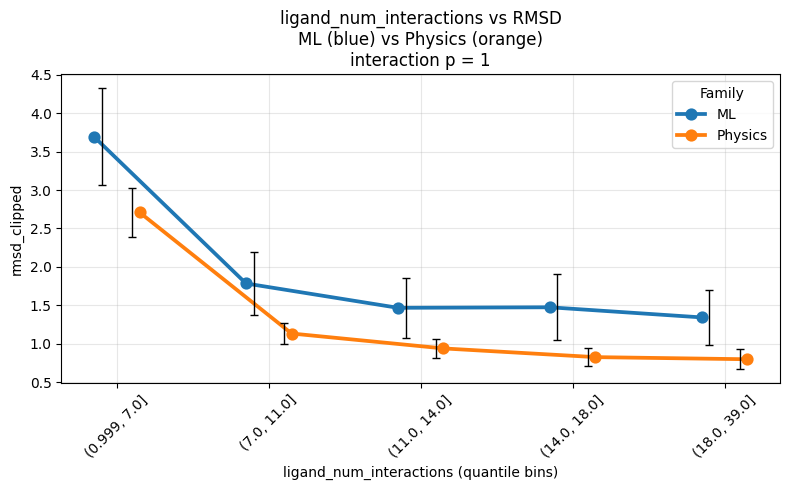

p_interaction: 1.0
                                                 Mixed Linear Model Regression Results
Model:                                       MixedLM                          Dependent Variable:                          rmsd_clipped
No. Observations:                            1806                             Method:                                      REML        
No. Groups:                                  916                              Scale:                                       4.5598      
Min. group size:                             1                                Log-Likelihood:                              -4144.5505  
Max. group size:                             2                                Converged:                                   Yes         
Mean group size:                             2.0                                                                                       
------------------------------------------------------------------------------

In [29]:
property = "ligand_num_interactions"
df_method = (
    df_mixed[[
        "rmsd",
        property,
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
print(df_method.shape)

property_analysis.analyze_comparative_fixed_effects(df_method, property, "Method_Type", "rmsd", "protein")

results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "gnina", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(f"p_interaction: {results['p_interaction']}")
print(results['model_full'].summary())
print(results['model_noint'].summary())


#### without gnina

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


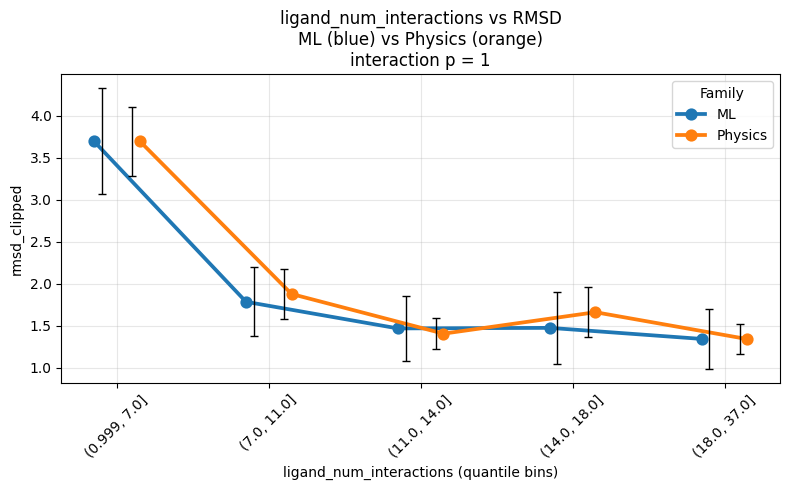

1.0
                                                 Mixed Linear Model Regression Results
Model:                                       MixedLM                          Dependent Variable:                          rmsd_clipped
No. Observations:                            1765                             Method:                                      REML        
No. Groups:                                  906                              Scale:                                       5.5143      
Min. group size:                             1                                Log-Likelihood:                              -4220.2322  
Max. group size:                             2                                Converged:                                   Yes         
Mean group size:                             1.9                                                                                       
---------------------------------------------------------------------------------------------

In [30]:
results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())

### ligand_num_neighboring_residues

### ligand_num_interacting_residues

In [ ]:
df_mixed = (
    df_mixed[[
        "rmsd",
        "ligand_num_interacting_residues",
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
df_mixed.shape

(12153, 4)

## GAM

### A Test Case for Mixed Effect Analysis, GAM, and Batch Testing

#### 1. Mixed-Effects Linear Model (per-property)

In [ ]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    "rmsd ~ ligand_num_interacting_residues * Method_Type",
    data=df_mixed,
    groups=df_mixed["protein"]
).fit()

print(model.summary())

                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          rmsd       
No. Observations:            12163            Method:                      REML       
No. Groups:                  462              Scale:                       117.5639   
Min. group size:             5                Log-Likelihood:              -46651.8153
Max. group size:             35               Converged:                   Yes        
Mean group size:             26.3                                                     
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    6.599    0.440 14.997 0.000  5.737  7.462
Method_Type[T.Physics]                      -1.770    0.345 -5.135 0

#### 2. Generalized Additive Model (to capture non-linearity)

In [ ]:
import numpy as np
from pygam import LinearGAM, s, f

# Encode Method_Type as 0 (Physics) / 1 (ML)
df = df_mixed.copy()
df["Method_Num"] = (df["Method_Type"] == "ML").astype(int)

X = df[["ligand_num_hba", "Method_Num"]].values
y = df["rmsd"].values

# s(0) is a spline on ligand_num_hba
# f(1) is a factor for Method_Num
# s(0, by=1) is an interaction spline (separate smooths per Method_Num)
gam = LinearGAM(s(0) + f(1) + s(0, by=1)).fit(X, y)

gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     31.1607
Link Function:                     IdentityLink Log Likelihood:                                -70827.4094
Number of Samples:                        12153 AIC:                                           141719.1403
                                                AICc:                                          141719.3163
                                                GCV:                                              135.6353
                                                Scale:                                            135.0095
                                                Pseudo R-Squared:                                   0.0297
Feature Function                  Lam

/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_29490/2918155216.py:16: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


#### 3. Batch Testing + FDR Correction (multiple properties)

In [ ]:
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf

properties = [
    'ligand_num_hba',
    'ligand_num_hbd',
    'ligand_molecular_weight',
    # … add more
]

results = []
for prop in properties:
    formula = f"rmsd ~ {prop} * Method_Type"
    m = smf.mixedlm(formula, data=df_mixed, groups=df_mixed["protein"]).fit()
    p_int = m.pvalues.get(f"{prop}:Method_Type[T.ML]", np.nan)
    results.append((prop, p_int))

# Pull out p-values and correct
props, pvals = zip(*results)
rejected, pvals_corrected, _, _ = multipletests(pvals, method="fdr_bh")

for prop, p_un, p_cor, rej in zip(props, pvals, pvals_corrected, rejected):
    print(f"{prop:20s}  p_int={p_un:.3g}  p_fdr={p_cor:.3g}  significant={rej}")

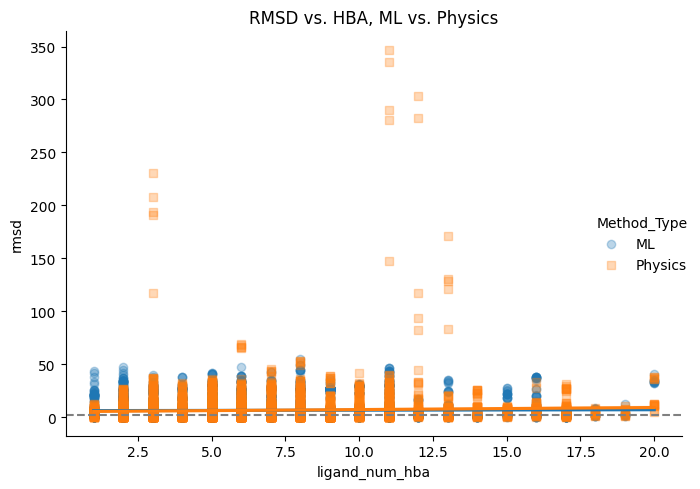

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(
    data=df_mixed,
    x="ligand_num_hba",
    y="rmsd",
    hue="Method_Type",
    scatter_kws={'alpha':0.3},
    height=5, aspect=1.2,
    markers=["o","s"]
)
plt.axhline(2.0, color='grey', linestyle='--', label="RMSD=2Å")
plt.title("RMSD vs. HBA, ML vs. Physics")
plt.tight_layout()
plt.show()

In [ ]:
# e.g. low (≤5), medium (6–10), high (>10) HBA
df_mixed['HBA_bin'] = pd.cut(df_mixed['ligand_num_hba'],
                                bins=[0,5,10,df_mixed.ligand_num_hba.max()],
                                labels=['low','med','high'])
summary = (
    df_mixed
    .assign(success=lambda d: d.rmsd < 2.0)
    .groupby(['HBA_bin','Method_Type'])
    .success
    .agg(['mean','count'])
    .rename(columns={'mean':'success_rate','count':'n'})
    .reset_index()
)
print(summary)

  HBA_bin Method_Type  success_rate     n
0     low          ML      0.518182  2640
1     low     Physics      0.238710  2325
2     med          ML      0.516879  2666
3     med     Physics      0.262417  2557
4    high          ML      0.454167   960
5    high     Physics      0.207960  1005
